In [1]:
pip install tensorflow==2.10 tensorflow-gpu==2.10 tensorflow-io==0.27 matplotlib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Mrinmoy\Documents\Portfolio\Audio Classification\audioclassification\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
pip list

Package                      Version
---------------------------- --------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.3.1
certifi                      2023.5.7
charset-normalizer           3.2.0
colorama                     0.4.6
comm                         0.1.3
contourpy                    1.1.0
cycler                       0.11.0
debugpy                      1.6.7
decorator                    5.1.1
executing                    1.2.0
flatbuffers                  23.5.26
fonttools                    4.41.0
gast                         0.4.0
google-auth                  2.22.0
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.56.0
h5py                         3.9.0
idna                         3.4
importlib-metadata           6.8.0
importlib-resources          6.0.0
ipykernel                    6.24.0
ipython

You should consider upgrading via the 'C:\Users\Mrinmoy\Documents\Portfolio\Audio Classification\audioclassification\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
#tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav,axis=1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav,rate_in=sample_rate,rate_out=16000)
    return wav

In [5]:
POS = os.path.join('data','Parsed_Capuchinbird_Clips')
NEG = os.path.join('data','Parsed_not_Capuchinbird_Clips')

In [6]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [7]:
positives = tf.data.Dataset.zip((pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [8]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))


In [9]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [10]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [11]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [12]:
def preprocess (file_path,label):
    wav = load_wav(file_path)
    wav = wav[:48000]
    zero_pad = tf.zeros([48000]-tf.shape(wav), dtype = tf.float32)
    wav = tf.concat([zero_pad,wav],0)
    spectrogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram , axis = 2)
    return spectrogram, label
    

In [13]:
file_path, label = positives.shuffle(buffer_size = 10000).as_numpy_iterator().next()

In [14]:
spectrogram, label = preprocess(file_path,label)

<function matplotlib.pyplot.show(close=None, block=None)>

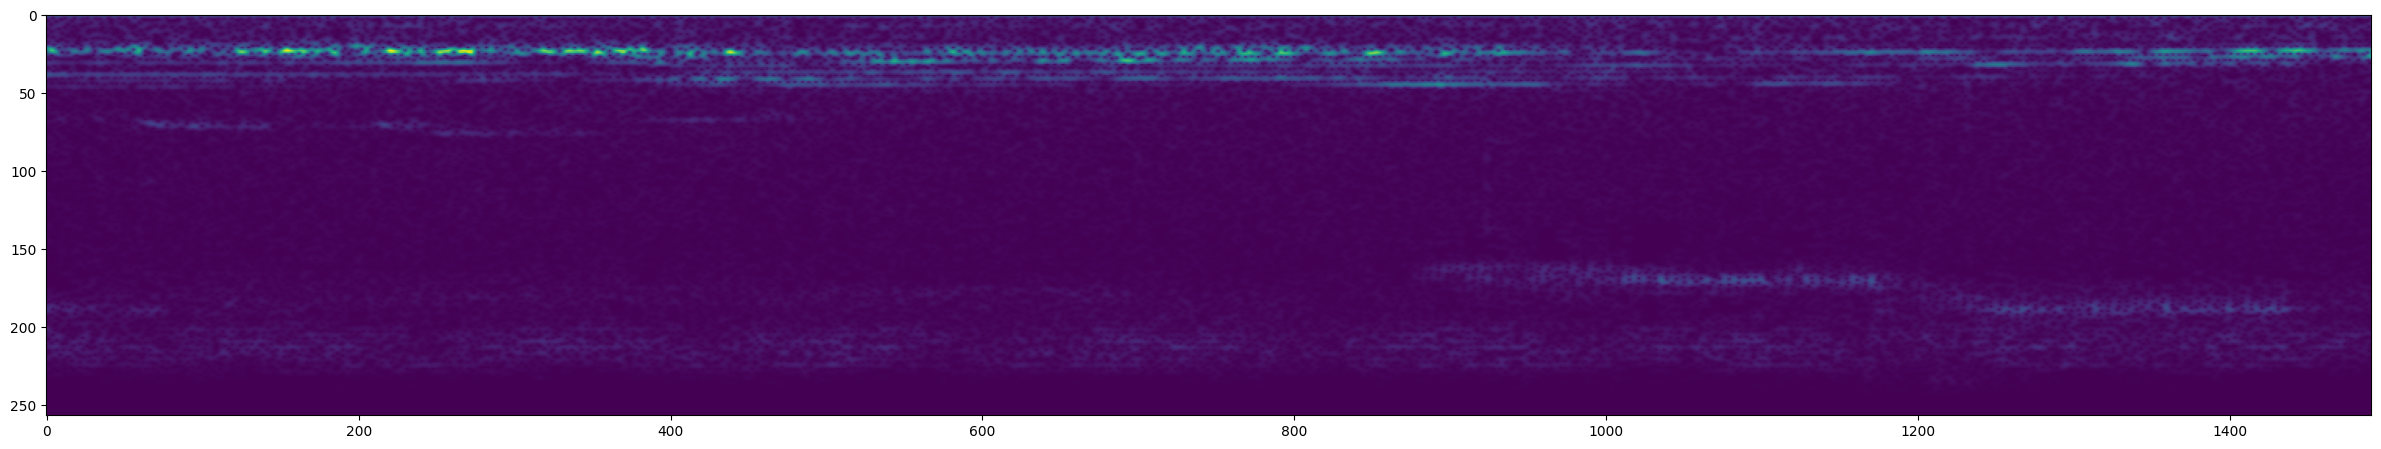

In [15]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show

In [16]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(8)
data = data.prefetch(8)

In [17]:
len(data)

102

In [18]:
train = data.take(72)
test = data.skip(72).take(30)

In [19]:
samples,labels = train.as_numpy_iterator().next()

In [20]:
samples.shape

(8, 1491, 257, 1)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [22]:
model = Sequential()
model.add(Conv2D(8,(3,3), activation='relu', input_shape=(1491,257,1)))
model.add(Conv2D(8,(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [23]:
model.compile('Adam', loss = 'BinaryCrossentropy', metrics = [tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 8)      80        
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 8)      584       
                                                                 
 flatten (Flatten)           (None, 3009688)           0         
                                                                 
 dense (Dense)               (None, 64)                192620096 
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 192,620,825
Trainable params: 192,620,825
Non-trainable params: 0
_________________________________________________________________


In [25]:
hist = model.fit(train, epochs=4,validation_data=test)

Epoch 1/4
72/72 [==============================] - 10s 78ms/step - loss: 0.6282 - recall: 0.9264 - precision: 0.8678 - val_loss: 0.0645 - val_recall: 1.0000 - val_precision: 0.9828
Epoch 2/4
72/72 [==============================] - 5s 75ms/step - loss: 0.0572 - recall: 1.0000 - precision: 0.9936 - val_loss: 0.0010 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/4
72/72 [==============================] - 6s 77ms/step - loss: 0.1778 - recall: 0.9735 - precision: 0.9671 - val_loss: 0.0684 - val_recall: 1.0000 - val_precision: 0.9853
Epoch 4/4
72/72 [==============================] - 5s 72ms/step - loss: 0.0438 - recall: 0.9935 - precision: 0.9935 - val_loss: 0.0279 - val_recall: 1.0000 - val_precision: 1.0000


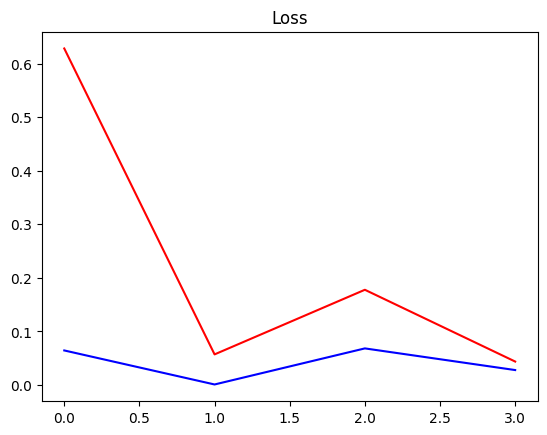

In [26]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

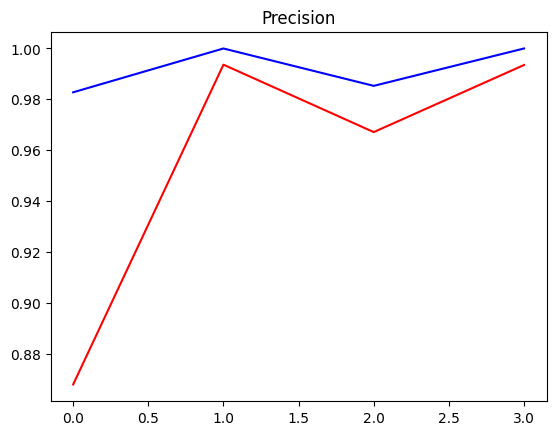

In [27]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

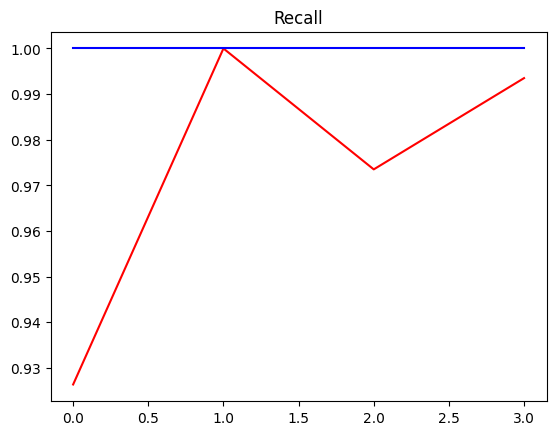

In [28]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [29]:
X_test, y_test = test.as_numpy_iterator().next()

In [30]:
X_test.shape

(8, 1491, 257, 1)

In [31]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 114ms/step


In [32]:
yhat

array([[1.0000000e+00],
       [3.7077112e-05],
       [8.1446028e-10],
       [1.6342740e-09],
       [6.5344269e-05],
       [1.0000000e+00],
       [3.0599587e-04],
       [3.4868076e-01]], dtype=float32)

In [33]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [34]:
yhat

[1, 0, 0, 0, 0, 1, 0, 0]

In [35]:
y_test.astype(int)

array([1, 0, 0, 0, 0, 1, 0, 0])

In [36]:
def load_mp3(filename):
    res = tfio.audio.AudioIOTensor(filename)
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor,axis=1)/2
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate,dtype=tf.int64)
    wav = tfio.audio.resample(tensor,rate_in=sample_rate,rate_out=16000)
    return wav

In [37]:
mp3 = os.path.join('data','Forest Recordings','recording_00.mp3')

In [38]:
wav = load_mp3(mp3)

In [39]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length = 48000, sequence_stride = 48000,batch_size = 1)

In [40]:
samples, index = audio_slices.as_numpy_iterator().next()

In [41]:
samples.shape

(1, 48000)

In [42]:
index

array([8.143327e-12], dtype=float32)

In [43]:
len(audio_slices)

60

In [44]:
def preprocess_mp3 (sample, index):
    sample = sample[0]
    zero_pad = tf.zeros([48000]-tf.shape(sample), dtype = tf.float32)
    wav = tf.concat([zero_pad,sample],0)
    spectrogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram , axis = 2)
    return spectrogram

In [45]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [46]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > .99 else 0 for prediction in yhat]

3/3 [==============================] - 2s 230ms/step


In [47]:
len(yhat)

180

In [48]:
from itertools import groupby

In [49]:
yhat = [key for key, group in groupby(yhat)]

In [50]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [51]:
calls = tf.math.reduce_sum(yhat).numpy()

In [52]:
results = {}
for file in os.listdir(os.path.join('data','Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings',file)
    wav = load_mp3(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    yhat = model.predict(audio_slices)
    
    results[file] = yhat
    

1/1 [==============================] - 0s 476ms/step


In [53]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > .99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

In [54]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 25,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 2,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 1,
 'recording_16.mp3': 5,
 'recording_17.mp3': 6,
 'recording_18.mp3': 3,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 8,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 16,
 'recording_29.mp3': 0,
 'recording_30.mp3': 3,
 'recording_31.mp3': 1,
 'recording_32.mp3': 1,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 5,
 'recording_39.mp3': 5,
 'recording_40.mp3': 1,
 'recording_41

In [55]:
import csv

In [56]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])